In [1]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cluster import HDBSCAN
from sklearn.model_selection import train_test_split
import numpy as np
from drfp import DrfpEncoder

2024-05-19 21:13:40.132511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 21:13:40.246871: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-19 21:13:43.426638: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-19 21:13:43.426868: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

# Data preparation

In [2]:
# The dataset obtained in the 1_uspto_processing.ipynb notebook
test = pd.read_csv('US_patents_1976-Sep2016_1product_reactions_yield_ok_cropped_data_test.csv', sep='\t', index_col = 0)
valid = pd.read_csv('US_patents_1976-Sep2016_1product_reactions_yield_ok_cropped_data_valid.csv', sep='\t', index_col = 0)
train = pd.read_csv('US_patents_1976-Sep2016_1product_reactions_yield_ok_cropped_data_train.csv', sep='\t', index_col = 0)
print(test.shape)
print(valid.shape)
print(train.shape)

(26404, 6)
(26101, 6)
(473963, 6)


In [3]:
df = pd.concat([test, valid, train])
df = df.drop(['myID', 'Source', 'Target', 'OriginalReaction'], axis=1)

def split_reaction(reaction_smiles):
  
  """This function splits reaction SMILES into reactants, reagents and product."""
  
  d = dict()
  if '>>' in reaction_smiles:
    react_list = reaction_smiles.split('>>')
    d['reactants'] = react_list[0]
    d['products'] = react_list[1]
  else:
    react_list = reaction_smiles.split('>')
    d['reactants'] = react_list[0]
    d['reagents'] = react_list[1]
    d['products'] = react_list[2]
  return d

# Split reaction SMILES into dictionaries
df['ReactionDict'] = df.standard_reaction_smiles.apply(split_reaction)

# Split dictionaries into separate columns
df['reactants'] = df.ReactionDict.apply(lambda x: x['reactants'])
df['reagents'] = df.ReactionDict.apply(lambda x: x['reagents'] if 'reagents' in x.keys() else None)
df['products'] = df.ReactionDict.apply(lambda x: x['products'])

# Split strings into lists
df['reactants'] = df.reactants.apply(lambda x: x.split('.'))
df['reagents'] = df.reagents.apply(lambda x: x.split('.') if x!=None else None)
df['products'] = df.products.apply(lambda x: x.split('.'))

# Drop reactions with >2 reactants
df['Len'] = df.reactants.apply(lambda x: len(x))
df = df[df.Len.isin([1, 2])]

In [ ]:
# Drop unnecessary columns
df = df[['standard_reaction_smiles', 'yields']]
df.reset_index(drop=True, inplace=True)
df.head()

In [ ]:
def get_drfp(reaction_smiles, n_folded_length=2048, radius=2):
  
  """This function converts reaction SMILES into differential reaction fingerprints (DRFP)."""
  
  fp = DrfpEncoder.encode(reaction_smiles, n_folded_length=n_folded_length, radius=radius)
  return fp[0]

In [ ]:
# Convert reaction SMILES into DRFPs
X = [get_drfp(smi) for smi in df.standard_reaction_smiles]

# Dimensionality reduction with UMAP

In [ ]:
emb = umap.UMAP(metric='kulsinski').fit_transform(X)
plt.figure(figsize=(10, 8))
plt.scatter(emb[:, 0], emb[:, 1], cmap='viridis', s=5)
plt.show()

In [ ]:
np.save('uspto_emb_kulsinski.npy', emb)

# Clustering with HDBSCAN

In [5]:
emb = np.load('uspto_emb_kulsinski.npy')

In [6]:
hdb = HDBSCAN(min_cluster_size=2000, max_cluster_size=60000, store_centers='centroid').fit(emb)

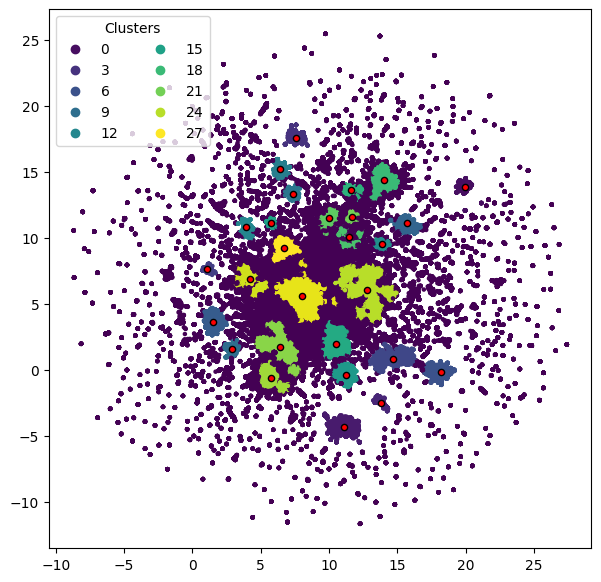

In [13]:
fig, ax = plt.subplots(figsize=(7, 7))
sc = ax.scatter(emb[:, 0], emb[:, 1], c=hdb.labels_, s=5)
cent = ax.scatter(hdb.centroids_[:, 0], hdb.centroids_[:, 1], color='red', edgecolors='black', s=20)
ax.legend(*sc.legend_elements(), title='Clusters', ncols=2, loc='upper left', scatterpoints=2)
#plt.savefig('uspto_clustering.jpg', format='jpg', dpi=500, bbox_inches='tight')
plt.show()

# USPTO-R dataset

In [14]:
# Create dataset with SMILES, UMAP embeddings, clusters and yields
dfc = pd.DataFrame({'smiles': df.CanonicalizedReaction.tolist(), 'x': list(emb[:, 0]), 'y': list(emb[:, 1]), 'cluster': hdb.labels_, 'yields': df.Yield.tolist()})
dfc.cluster.value_counts()

cluster
-1     223214
 24     36307
 26     35698
 22     26593
 18     16666
 16     14235
 27     13031
 23     12189
 5      11590
 6      10126
 1      10095
 25      9440
 14      9298
 20      7568
 19      6143
 7       5437
 3       5018
 17      4570
 0       4139
 11      3901
 8       3874
 12      3375
 21      3284
 10      3204
 9       2610
 13      2548
 2       2406
 4       2340
 15      2263
Name: count, dtype: int64

In [15]:
dfc.shape

(491162, 5)

In [16]:
# Randomly sample 11000 reactions
df_rand = dfc.sample(n=11000, random_state=42)
df_rand.reset_index(drop=True, inplace=True)

# Sample 100 reactions for the test subset
X_train, X_test, y_train, y_test = train_test_split(df_rand.smiles,
                                                    df_rand.yields,
                                                    test_size=100/11000,
                                                    random_state=42)

In [18]:
# Randomly sample 300 reactions for the validation subset
dfc_left = pd.concat([dfc, df_rand]).drop_duplicates(keep=False)
df_val = dfc_left.sample(n=300, random_state=42)
df_val.shape

(300, 5)

In [19]:
# Add the split column
df_val['split'] = 'val'
df_val.head()

,smiles,x,y,cluster,yields,split
487438,CC(=O)C1CCC1.NC(=O)c1c(NC(=O)Nc2ccc(Cl)cc2)sc2...,11.046062,-0.267675,14,53.4,val
190326,C#CCO.Cn1cc(C(=O)NCc2ccc(Cl)cc2)c(=O)c2sc(I)cc...,11.266688,13.786441,17,68.7,val
266554,C1COCCN1.CN(c1cccc2cc(C3=NCC(CC(=O)O)S3)[nH]c1...,7.572349,0.862870,22,57.0,val
367927,[Li]CCCC.c1ccc2c(c1)CC1=C2CCCC1>C1CCOC1.CCBr.C...,7.153759,9.157934,27,75.0,val
309018,CC[C@@H](C)Nc1cc(C(=O)OC)c(C(F)(F)F)cc1C#N.O=C...,3.882227,3.480514,-1,57.0,val


In [21]:
# Add the split column
for idx in df_rand.index:
  if idx in y_test.index:
    df_rand.loc[idx, 'split'] = 'test'
  else:
    df_rand.loc[idx, 'split'] = 'train'
df_rand.split.value_counts()

split
train    10900
test       100
Name: count, dtype: int64

In [22]:
# Concatenate train, test and validation subsets
df_rand = pd.concat([df_rand, df_val])
df_rand

,smiles,x,y,cluster,yields,split
0,CC(C)C[C@H](NC(=O)OC(C)(C)C)C(=O)O.O=C1CCC(=O)...,7.362986,1.814589,22,90.1,train
1,C1CCNCC1.CC(C)(C)OC(=O)n1nc(I)c2sc(COS(C)(=O)=...,11.612656,7.314533,24,53.5,train
2,CC(=O)OC(C(=O)c1ccc(F)c2ccccc12)C(C)C.N#CN>CC(...,9.200765,5.518745,26,6.0,train
3,COc1ccc(C2CCc3cc(OC(=O)C(C)(C)C)ccc3C2)c(NCC(=...,2.263761,21.454762,-1,6.1,train
4,COc1cc(F)ccc1-c1ccc2c(c1CO)NC(=O)C(C)(C)N2.CS(...,10.807860,6.253698,-1,68.0,train
...,...,...,...,...,...,...
325732,Cn1ccc2c(Nc3nc(On4nnc5ccccc54)ncc3C(N)=O)cccc2...,8.983100,10.534839,-1,45.2,val
107224,CC(=O)OC(C)=O.OC1CN2CCC1CC2>c1ccncc1>CC(=O)OC1...,5.879408,3.496908,22,62.0,val
414975,CC(C)(O)CCl.N#Cc1ccc(O)cc1>CCO.O.O=C([O-])[O-]...,14.266515,5.087730,-1,94.0,val
312447,Fc1cc(F)cc(CBr)c1.O=C(c1c[nH]c2cc(Cl)ccc12)C(F...,12.932483,7.823291,24,64.0,val


In [ ]:
# Convert yield values into binary classification labels
df_rand_1 = df_rand[['smiles', 'yields', 'split']]
df_rand_1['high_yielding'] = df_rand_1.yields.apply(lambda x: 0 if x < 70 else 1)
df_rand_1['not_high_yielding'] = df_rand_1.yields.apply(lambda x: 0 if x >= 70 else 1)
df_rand_1.drop(columns=['yields'], inplace=True)
df_rand_1.head()

In [25]:
df_rand_1.split.value_counts()

split
train    10900
val        300
test       100
Name: count, dtype: int64

In [26]:
df_rand_1.to_csv('USPTO_R_smiles.csv', index=False)

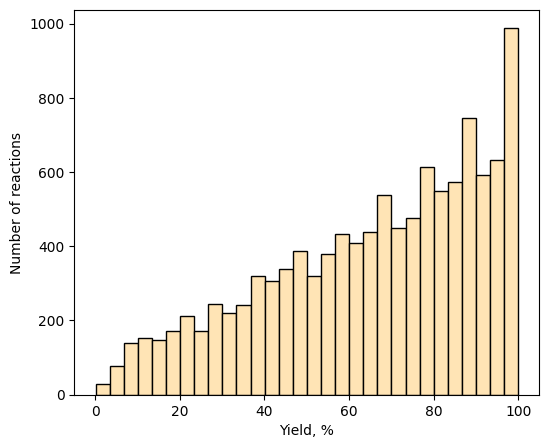

In [65]:
# Distribution of yield values in the USPTO-R dataset
fig, ax = plt.subplots(figsize=(6, 5))
plt.hist(df_rand_1.yields, bins=30, color='moccasin', edgecolor='black')
plt.xlabel('Yield, %')
plt.ylabel('Number of reactions')
#plt.savefig('uspto_r_yields.jpg', format='jpg', dpi=500, bbox_inches='tight')
plt.show()

# USPTO-C dataset

In [27]:
# Drop the -1 (noise) cluster
df_clusters = dfc[dfc.cluster != -1]
df_clusters.reset_index(drop=True, inplace=True)
df_clusters.cluster.value_counts()

cluster
24    36307
26    35698
22    26593
18    16666
16    14235
27    13031
23    12189
5     11590
6     10126
1     10095
25     9440
14     9298
20     7568
19     6143
7      5437
3      5018
17     4570
0      4139
11     3901
8      3874
12     3375
21     3284
10     3204
9      2610
13     2548
2      2406
4      2340
15     2263
Name: count, dtype: int64

In [28]:
# Calculate cluster centroids
centroids = dict(zip([i for i in range(0, (len(hdb.centroids_)))], hdb.centroids_))
centroids

{0: array([19.95952318, 13.87566662]),
 1: array([11.13083953, -4.3392061 ]),
 2: array([13.84034271, -2.49213679]),
 3: array([ 7.58105835, 17.61372527]),
 4: array([1.0950659 , 7.64429312]),
 5: array([14.70685867,  0.81488032]),
 6: array([18.16879681, -0.18763817]),
 7: array([1.53567367, 3.64358233]),
 8: array([15.7362099 , 11.15035893]),
 9: array([2.90113475, 1.56604022]),
 10: array([ 7.37554239, 13.3141727 ]),
 11: array([ 6.42870456, 15.23317534]),
 12: array([ 3.94839666, 10.8387026 ]),
 13: array([13.87017643,  9.54199938]),
 14: array([11.2495726 , -0.37856917]),
 15: array([ 5.78889935, 11.12081179]),
 16: array([10.50202152,  1.99667478]),
 17: array([11.6238443 , 13.60587672]),
 18: array([13.99699784, 14.40490388]),
 19: array([11.4348703, 10.0408289]),
 20: array([10.02704894, 11.52902378]),
 21: array([11.70203546, 11.61701107]),
 22: array([6.40154133, 1.73358884]),
 23: array([ 5.77585863, -0.63519377]),
 24: array([12.79321333,  6.08958396]),
 25: array([4.243207

In [29]:
df_clusters['centroid_x'] = df_clusters.cluster.apply(lambda x: centroids[x][0] if x!=-1 else None)
df_clusters['centroid_y'] = df_clusters.cluster.apply(lambda x: centroids[x][1] if x!=-1 else None)
df_clusters

/tmp/ipykernel_4028190/1590850963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters['centroid_x'] = df_clusters.cluster.apply(lambda x: centroids[x][0] if x!=-1 else None)
/tmp/ipykernel_4028190/1590850963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters['centroid_y'] = df_clusters.cluster.apply(lambda x: centroids[x][1] if x!=-1 else None)


,smiles,x,y,cluster,yields,centroid_x,centroid_y
0,CC(C)(C)NNC(C)(C#N)C1CC1.O=C1CCCCCC1>CC(=O)C1C...,8.590092,5.497380,26,95.0,8.049766,5.596900
1,CO.O=C(O)CCC(=O)c1ccccc1O>Cl>COC(=O)CCC(=O)c1c...,10.538355,-4.944224,1,98.0,11.130840,-4.339206
2,CCOC(=O)C(C)c1ccc2c(c1)Cc1cccnc1S2>CCO.O.[Na+]...,11.662202,-4.562418,1,88.3,11.130840,-4.339206
3,CC(C(=O)O)c1ccc(O)c(C(=O)c2cccnc2Cl)c1>I[Cu]I....,8.260999,6.117356,26,72.7,8.049766,5.596900
4,Cc1cc(O)c(SCc2ccc(F)cc2)c(=O)o1.OO>CC(=O)O.O>C...,13.882857,9.822329,13,60.0,13.870176,9.541999
...,...,...,...,...,...,...,...
267943,COc1cccc(OC)c1-c1c2ccc(n2)c(-c2c(OC)cccc2OC)c2...,6.373951,15.196939,11,87.0,6.428705,15.233175
267944,CCCCCCOc1ccc(O)cc1.O=C(O)c1ccc(OCc2ccccc2)cc1>...,6.428627,3.099725,22,70.3,6.401541,1.733589
267945,Brc1ccc(Br)nc1.OB(O)c1ccc(F)cc1F>CC#N.CC(=O)O[...,13.828969,14.258940,18,84.0,13.996998,14.404904
267946,Cc1cc(Cl)cc(C)c1B1OC(C)(C)C(C)(C)O1.Fc1ccc(-c2...,13.377860,13.230632,18,86.0,13.996998,14.404904


In [30]:
def dictance_to_centroid(dot_x, dot_y, centroid_x, centroid_y):
    
    """This function calculates the euclidean distance between the point and the cluster centroid."""
    
    dot = np.array((dot_x, dot_y))
    centroid = np.array((centroid_x, centroid_y))
    return np.linalg.norm(dot - centroid)

In [31]:
# Calculate the distance to the centroid for each point
for idx in df_clusters.index:
    dot_x = df_clusters.loc[idx, 'x']
    dot_y = df_clusters.loc[idx, 'y']
    centroid_x = df_clusters.loc[idx, 'centroid_x']
    centroid_y = df_clusters.loc[idx, 'centroid_y']
    distance = dictance_to_centroid(dot_x, dot_y, centroid_x, centroid_y)
    df_clusters.loc[idx, 'distance'] = distance
df_clusters

/tmp/ipykernel_4028190/913589447.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters.loc[idx, 'distance'] = distance


,smiles,x,y,cluster,yields,centroid_x,centroid_y,distance
0,CC(C)(C)NNC(C)(C#N)C1CC1.O=C1CCCCCC1>CC(=O)C1C...,8.590092,5.497380,26,95.0,8.049766,5.596900,0.549414
1,CO.O=C(O)CCC(=O)c1ccccc1O>Cl>COC(=O)CCC(=O)c1c...,10.538355,-4.944224,1,98.0,11.130840,-4.339206,0.846808
2,CCOC(=O)C(C)c1ccc2c(c1)Cc1cccnc1S2>CCO.O.[Na+]...,11.662202,-4.562418,1,88.3,11.130840,-4.339206,0.576341
3,CC(C(=O)O)c1ccc(O)c(C(=O)c2cccnc2Cl)c1>I[Cu]I....,8.260999,6.117356,26,72.7,8.049766,5.596900,0.561689
4,Cc1cc(O)c(SCc2ccc(F)cc2)c(=O)o1.OO>CC(=O)O.O>C...,13.882857,9.822329,13,60.0,13.870176,9.541999,0.280616
...,...,...,...,...,...,...,...,...
267943,COc1cccc(OC)c1-c1c2ccc(n2)c(-c2c(OC)cccc2OC)c2...,6.373951,15.196939,11,87.0,6.428705,15.233175,0.065658
267944,CCCCCCOc1ccc(O)cc1.O=C(O)c1ccc(OCc2ccccc2)cc1>...,6.428627,3.099725,22,70.3,6.401541,1.733589,1.366405
267945,Brc1ccc(Br)nc1.OB(O)c1ccc(F)cc1F>CC#N.CC(=O)O[...,13.828969,14.258940,18,84.0,13.996998,14.404904,0.222574
267946,Cc1cc(Cl)cc(C)c1B1OC(C)(C)C(C)(C)O1.Fc1ccc(-c2...,13.377860,13.230632,18,86.0,13.996998,14.404904,1.327496


In [32]:
# Sort reactions by distance within each cluster
df_clusters = df_clusters.sort_values(by=['cluster', 'distance'])
df_clusters

,smiles,x,y,cluster,yields,centroid_x,centroid_y,distance
142738,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.C[C@@H](N)C(=O)O...,19.956726,13.871693,0,63.0,19.959523,13.875667,0.004860
155657,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.CCOC(=O)C[C@H]1C...,19.940231,13.881252,0,60.1,19.959523,13.875667,0.020084
212376,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.C[C@H](c1ccccc1)...,19.936506,13.873768,0,71.6,19.959523,13.875667,0.023095
221466,CCOC(=O)c1cnn(-c2nc3cc(SSc4ccccc4[N+](=O)[O-])...,19.934595,13.878407,0,58.4,19.959523,13.875667,0.025078
11957,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.NCCc1ccc(Br)cc1>...,19.937166,13.888083,0,22.7,19.959523,13.875667,0.025573
...,...,...,...,...,...,...,...,...
218985,C[Mg]Br.N#Cc1ccc(Br)cc1F>C1CCOC1.CCOCC.CO.[BH4...,6.038535,8.277754,27,44.0,6.729081,9.251388,1.193657
208135,CC[Mg]Br.N#Cc1cccc(Cl)n1>C1CCOC1.CC(C)[O-].[Ti...,6.140934,8.211979,27,14.1,6.729081,9.251388,1.194273
226716,C[Mg]Br.Cn1ccc2nc(C#N)c(N3CC4(COC4)C3)cc21>C1C...,6.046139,8.264936,27,47.0,6.729081,9.251388,1.199790
246015,CCOC(=O)c1cc2ccc(OCc3ccc(F)cc3)cc2nc1C>C1CCOC1...,5.952290,8.327556,27,90.6,6.729081,9.251388,1.207009


In [33]:
# Dictionary {cluster label: number of reactions in a cluster}
clusters_dict = dict(zip(df_clusters.cluster.value_counts().keys(), df_clusters.cluster.value_counts().values))
clusters_dict

{24: 36307,
 26: 35698,
 22: 26593,
 18: 16666,
 16: 14235,
 27: 13031,
 23: 12189,
 5: 11590,
 6: 10126,
 1: 10095,
 25: 9440,
 14: 9298,
 20: 7568,
 19: 6143,
 7: 5437,
 3: 5018,
 17: 4570,
 0: 4139,
 11: 3901,
 8: 3874,
 12: 3375,
 21: 3284,
 10: 3204,
 9: 2610,
 13: 2548,
 2: 2406,
 4: 2340,
 15: 2263}

In [34]:
# Select closest to the centroid reactions from each cluster proportionally to the size of the cluster
frames = []
for cltr, n in clusters_dict.items():
  dfx = df_clusters[df_clusters.cluster==cltr]
  dfx.reset_index(drop=True, inplace=True)
  dfx = dfx.loc[:int(np.round(9000*n/df_clusters.shape[0], 0))]
  frames.append(dfx)

In [35]:
df_new = pd.concat(frames)

In [36]:
df_clusters_left = pd.concat([df_clusters, df_new]).drop_duplicates(keep=False)
df_clusters_left

,smiles,x,y,cluster,yields,centroid_x,centroid_y,distance
15776,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.NCc1ccccc1N>CN(C...,20.052771,13.936326,0,75.0,19.959523,13.875667,0.111241
6099,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.COc1ccc(CCN2C(=O...,19.975485,13.765505,0,87.5,19.959523,13.875667,0.111312
221659,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.N=c1n(CCCOc2cccc...,20.023367,13.784081,0,51.3,19.959523,13.875667,0.111642
174977,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.O=C(O)[C@]1(Cc2c...,20.053211,13.937099,0,41.0,19.959523,13.875667,0.112033
258407,COC(=O)OC.COc1cc(Nc2ncc3c(n2)CCNC3)cc(OC)c1OC>...,19.986509,13.765655,0,64.0,19.959523,13.875667,0.113274
...,...,...,...,...,...,...,...,...
218985,C[Mg]Br.N#Cc1ccc(Br)cc1F>C1CCOC1.CCOCC.CO.[BH4...,6.038535,8.277754,27,44.0,6.729081,9.251388,1.193657
208135,CC[Mg]Br.N#Cc1cccc(Cl)n1>C1CCOC1.CC(C)[O-].[Ti...,6.140934,8.211979,27,14.1,6.729081,9.251388,1.194273
226716,C[Mg]Br.Cn1ccc2nc(C#N)c(N3CC4(COC4)C3)cc21>C1C...,6.046139,8.264936,27,47.0,6.729081,9.251388,1.199790
246015,CCOC(=O)c1cc2ccc(OCc3ccc(F)cc3)cc2nc1C>C1CCOC1...,5.952290,8.327556,27,90.6,6.729081,9.251388,1.207009


In [37]:
df_new.reset_index(drop=True, inplace=True)

In [38]:
# Sample 100 reactions for the test set
X_train, X_test, y_train, y_test = train_test_split(df_new.x,
                                                    df_new.cluster,
                                                    test_size=100/df_new.shape[0],
                                                    random_state=42,
                                                    stratify=df_new.cluster)
y_test.shape

(100,)

In [39]:
# Add the split column
for idx in df_new.index:
  if idx in y_test.index:
    df_new.loc[idx, 'split'] = 'test'
  else:
    df_new.loc[idx, 'split'] = 'train'
df_new.split.value_counts()

split
train    8928
test      100
Name: count, dtype: int64

In [40]:
# Sample 300 reactions for the validation set
X_train1, X_test1, y_train1, y_test1 = train_test_split(df_clusters_left.x,
                                                    df_clusters_left.cluster,
                                                    test_size=300/df_clusters_left.shape[0],
                                                    random_state=42,
                                                    stratify=df_clusters_left.cluster)
y_test1.shape

(300,)

In [42]:
# Add the split column
for idx in df_clusters_left.index:
  if idx in y_test1.index:
    df_clusters_left.loc[idx, 'split'] = 'val'
  else:
    pass
df_clusters_left.split.value_counts()

split
val    300
Name: count, dtype: int64

In [43]:
df_new_val = df_clusters_left[df_clusters_left.split=='val']
df_new_val.shape

(300, 9)

In [44]:
df_new_val.reset_index(drop=True, inplace=True)
df_new_val

,smiles,x,y,cluster,yields,centroid_x,centroid_y,distance,split
0,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.O=C1NC(Cc2ccc(C(...,19.723381,13.784394,0,90.2,19.959523,13.875667,0.253167,val
1,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.O=C(O)C1CSC(c2cc...,19.985792,13.606238,0,80.0,19.959523,13.875667,0.270706,val
2,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.OC[C@@H]1CCCN1>C...,20.004065,13.600180,0,95.5,19.959523,13.875667,0.279064,val
3,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.CC(C)(CO)c1nnc(N...,19.631138,14.141013,0,76.0,19.959523,13.875667,0.422192,val
4,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.Nc1ccc(C(=O)O)c2...,19.714853,14.265073,0,57.4,19.959523,13.875667,0.459892,val
...,...,...,...,...,...,...,...,...,...
295,C=CCC(C)Br.Fc1ccc(CC[C@H]2CC[C@H](C3CC[SiH](Cl...,6.693557,8.513934,27,83.7,6.729081,9.251388,0.738309,val
296,C=CBr.CC(=O)/C=C/C1=C(C)CCCC1(C)C>C1CCOC1.II.[...,6.461377,8.418038,27,87.5,6.729081,9.251388,0.875292,val
297,CCC[N+](=O)[O-].O=Cc1cccnc1>C1CCOC1.[Al+3].[H-...,6.221182,8.463351,27,71.0,6.729081,9.251388,0.937530,val
298,CC(C)(C)[Si](OC1CCC(=O)C1COC(c1ccccc1)(c1ccccc...,7.651177,9.041330,27,91.7,6.729081,9.251388,0.945719,val


In [45]:
# Concatenate train, test and validation subsets
df_new = pd.concat([df_new, df_new_val])
df_new.reset_index(drop=True, inplace=True)

In [46]:
df_new.split.value_counts()

split
train    8928
val       300
test      100
Name: count, dtype: int64

In [47]:
# Drop unnecessary columns and convert yields into binary classification labels
df_new_1 = df_new[['smiles', 'yields', 'split']]
df_new_1['high_yielding'] = df_new_1.yields.apply(lambda x: 0 if x < 70 else 1)
df_new_1['not_high_yielding'] = df_new_1.yields.apply(lambda x: 0 if x >= 70 else 1)
df_new_1.drop(columns=['yields'], inplace=True)
df_new_1.head()

,smiles,yields,split
0,O=C(Nc1ccc(Br)c(F)c1[N+](=O)[O-])C(F)(F)F.O=C(...,90.4,train
1,C#C.C[Si](C)(C)CCCCCCO>CS(C)=O.[K+].[OH-]>C=CO...,99.0,train
2,CC1COC(=O)N1.CCCCCI>C1CCOC1.CCCCCC.O=S(=O)(O)O...,73.0,train
3,CCOC(=O)C(Cl)(Cl)C#N.CCOC(=O)CC#N>C=CC=O.CCOC(...,77.0,train
4,CCI.CCNc1ccc(Br)cc1C(C)(C)C>CS(C)=O.[Cl-].[H-]...,63.3,train


In [48]:
df_new_1.to_csv('USPTO_C_smiles.csv', index=False)

# Datasets visualization

In [49]:
df_new = pd.read_csv('USPTO_C_smiles.csv')
df_rand = pd.read_csv('USPTO_R_smiles.csv')

In [51]:
df['UMAP_1'] = emb[:, 0].tolist()
df['UMAP_2'] = emb[:, 1].tolist()
df.rename(columns={'CanonicalizedReaction': 'smiles'}, inplace=True)
df

,smiles,Yield,UMAP_1,UMAP_2
2,CC(C)(C)NNC(C)(C#N)C1CC1.O=C1CCCCCC1>CC(=O)C1C...,95.0,8.590092,5.497380
7,CC(C)N.O=C1CCC(c2ccc(OCC3CO3)cc2)=NN1>CO>CC(C)...,100.0,7.350268,-3.737920
8,CO.O=C(O)CCC(=O)c1ccccc1O>Cl>COC(=O)CCC(=O)c1c...,98.0,10.538355,-4.944224
13,CC(=O)c1ccc2c(c1)C(C)(C)c1cccnc1O2.[OH-]>BrBr....,78.6,7.572017,7.310540
14,CSc1ccc(N=C=O)cc1.OCc1cccnc1>C1CN2CCN1CC2.c1cc...,95.0,2.025015,12.109326
...,...,...,...,...
902576,COc1cccc(C(=N)Nc2c(C(C)C)cc(Br)cc2C(C)C)c1.O=C...,79.0,9.201713,5.026521
902577,O=[N+]([O-])c1ccccc1-c1ccc(Br)cc1>CCOP(OCC)OCC...,65.5,18.124718,4.538660
902578,Brc1ccc2c(c1)[nH]c1ccccc12.Ic1ccccn1>C1COCCO1....,43.2,12.370341,10.731225
902579,Brc1ccc2c3ccccc3n(-c3ccccn3)c2c1.[I-]>C1COCCO1...,83.1,12.542497,10.939238


In [52]:
df_new = df_new.merge(df[['smiles', 'UMAP_1', 'UMAP_2']], on='smiles')
df_rand = df_rand.merge(df[['smiles', 'UMAP_1', 'UMAP_2']], on='smiles')
df_rand

,smiles,yields,split,UMAP_1,UMAP_2
0,CC(C)C[C@H](NC(=O)OC(C)(C)C)C(=O)O.O=C1CCC(=O)...,90.1,train,7.362986,1.814589
1,C1CCNCC1.CC(C)(C)OC(=O)n1nc(I)c2sc(COS(C)(=O)=...,53.5,train,11.612656,7.314533
2,CC(=O)OC(C(=O)c1ccc(F)c2ccccc12)C(C)C.N#CN>CC(...,6.0,train,9.200765,5.518745
3,COc1ccc(C2CCc3cc(OC(=O)C(C)(C)C)ccc3C2)c(NCC(=...,6.1,train,2.263761,21.454762
4,COc1cc(F)ccc1-c1ccc2c(c1CO)NC(=O)C(C)(C)N2.CS(...,68.0,train,10.807860,6.253698
...,...,...,...,...,...
11295,Cn1ccc2c(Nc3nc(On4nnc5ccccc54)ncc3C(N)=O)cccc2...,45.2,val,8.983100,10.534839
11296,CC(=O)OC(C)=O.OC1CN2CCC1CC2>c1ccncc1>CC(=O)OC1...,62.0,val,5.879408,3.496908
11297,CC(C)(O)CCl.N#Cc1ccc(O)cc1>CCO.O.O=C([O-])[O-]...,94.0,val,14.266515,5.087730
11298,Fc1cc(F)cc(CBr)c1.O=C(c1c[nH]c2cc(Cl)ccc12)C(F...,64.0,val,12.932483,7.823291


In [54]:
df_new = df_new[df_new.split.isin(['test', 'train'])]

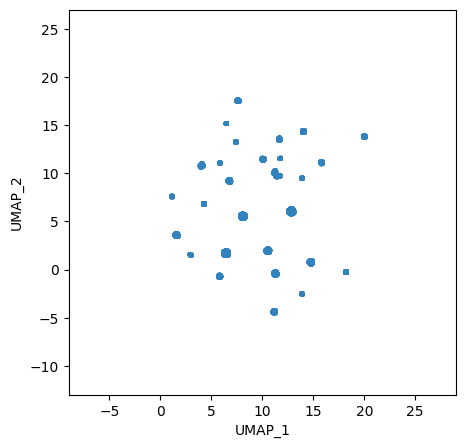

In [63]:
# USPTO-C
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(df_new.UMAP_1, df_new.UMAP_2, s=5, c='#3182bd')
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.xlim(-9, 29)
plt.ylim(-13, 27)
plt.savefig('uspto_c.jpg', format='jpg', dpi=600, bbox_inches='tight')
plt.show()

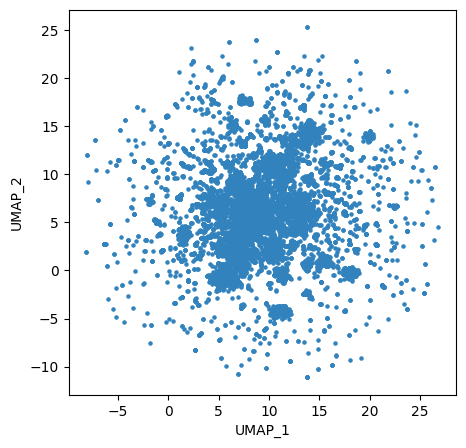

In [64]:
# USPTO-R
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(df_rand.UMAP_1, df_rand.UMAP_2, s=5, c='#3182bd')
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.savefig('uspto_r.jpg', format='jpg', dpi=600, bbox_inches='tight')
plt.show()

# Visualization of DRFPs and LLM embeddings

In [ ]:
# Generate 3d embeddings of DRFPs
emb_3d = umap.UMAP(metric='kulsinski', random_state=42, n_components=3, n_jobs=-1).fit_transform(X)
df['UMAP_1_3d'] = emb_3d[:, 0]
df['UMAP_2_3d'] = emb_3d[:, 1]
df['UMAP_3_3d'] = emb_3d[:, 2]

In [58]:
df_new = df_new.merge(df[['smiles', 'UMAP_1_3d', 'UMAP_2_3d', 'UMAP_3_3d']], on='smiles')
df_rand = df_rand.merge(df[['smiles', 'UMAP_1_3d', 'UMAP_2_3d', 'UMAP_3_3d']], on='smiles')
df_rand

,smiles,yields,split,UMAP_1,UMAP_2,UMAP_1_3d,UMAP_2_3d,UMAP_3_3d
0,CC(C)C[C@H](NC(=O)OC(C)(C)C)C(=O)O.O=C1CCC(=O)...,90.1,train,7.362986,1.814589,12.527063,9.911126,1.247768
1,C1CCNCC1.CC(C)(C)OC(=O)n1nc(I)c2sc(COS(C)(=O)=...,53.5,train,11.612656,7.314533,5.288729,8.632106,1.813863
2,CC(=O)OC(C(=O)c1ccc(F)c2ccccc12)C(C)C.N#CN>CC(...,6.0,train,9.200765,5.518745,8.406675,7.352192,3.520903
3,COc1ccc(C2CCc3cc(OC(=O)C(C)(C)C)ccc3C2)c(NCC(=...,6.1,train,2.263761,21.454762,5.714030,18.427128,0.176553
4,COc1cc(F)ccc1-c1ccc2c(c1CO)NC(=O)C(C)(C)N2.CS(...,68.0,train,10.807860,6.253698,6.170985,8.187519,1.496327
...,...,...,...,...,...,...,...,...
11295,Cn1ccc2c(Nc3nc(On4nnc5ccccc54)ncc3C(N)=O)cccc2...,45.2,val,8.983100,10.534839,10.870127,2.669276,2.356563
11296,CC(=O)OC(C)=O.OC1CN2CCC1CC2>c1ccncc1>CC(=O)OC1...,62.0,val,5.879408,3.496908,11.188977,9.468050,0.502290
11297,CC(C)(O)CCl.N#Cc1ccc(O)cc1>CCO.O.O=C([O-])[O-]...,94.0,val,14.266515,5.087730,3.659985,5.876454,1.867545
11298,Fc1cc(F)cc(CBr)c1.O=C(c1c[nH]c2cc(Cl)ccc12)C(F...,64.0,val,12.932483,7.823291,3.376023,8.609452,2.768813
